In [1]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
import tifffile as tif
import matplotlib.pyplot as plt

imageTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
maskTransform = transforms.Compose([transforms.ToTensor()])

class LandslideDataset(Dataset):
    train_list = None
    train_mask = None
    test_list = None
    test_mask = None

    @classmethod
    def splitData(cls, dataset_dir):
        image_dir = os.path.join(dataset_dir, "img")
        mask_dir = os.path.join(dataset_dir, "mask")

        all_images = sorted(os.listdir(image_dir))
        train_set, test_set = train_test_split(all_images, test_size=.2, random_state=42)
        cls.train_mask = [os.path.join(mask_dir, img_name) for img_name in train_set]
        cls.test_mask = [os.path.join(mask_dir, img_name) for img_name in test_set]
        cls.train_list = [os.path.join(image_dir, img_name) for img_name in train_set]
        cls.test_list = [os.path.join(image_dir, img_name) for img_name in test_set]

    def __init__(self, isTrain):
        if(isTrain):
            self.img_list = LandslideDataset.train_list
            self.mask_list = LandslideDataset.train_mask
        else:
            self.img_list = LandslideDataset.test_list
            self.mask_list = LandslideDataset.test_mask
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img_dir = self.img_list[index]
        mask_dir = self.mask_list[index]

        img = img_dir
        mask = mask_dir

        img = tif.imread(img_dir)
        mask = tif.imread(mask_dir)

        img = imageTransform(img)
        mask = (maskTransform(mask) > 0).float()

        return img, mask


LandslideDataset.splitData("../data/Wenchuan")

train_dataset = LandslideDataset(isTrain=True)
test_dataset = LandslideDataset(isTrain=False)

# img, mask = train_dataset[0]
# plt.imshow(img)
# plt.axis("off")
# plt.show()

batch_size = 1

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testLoader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=0)

# U-Net Diagram

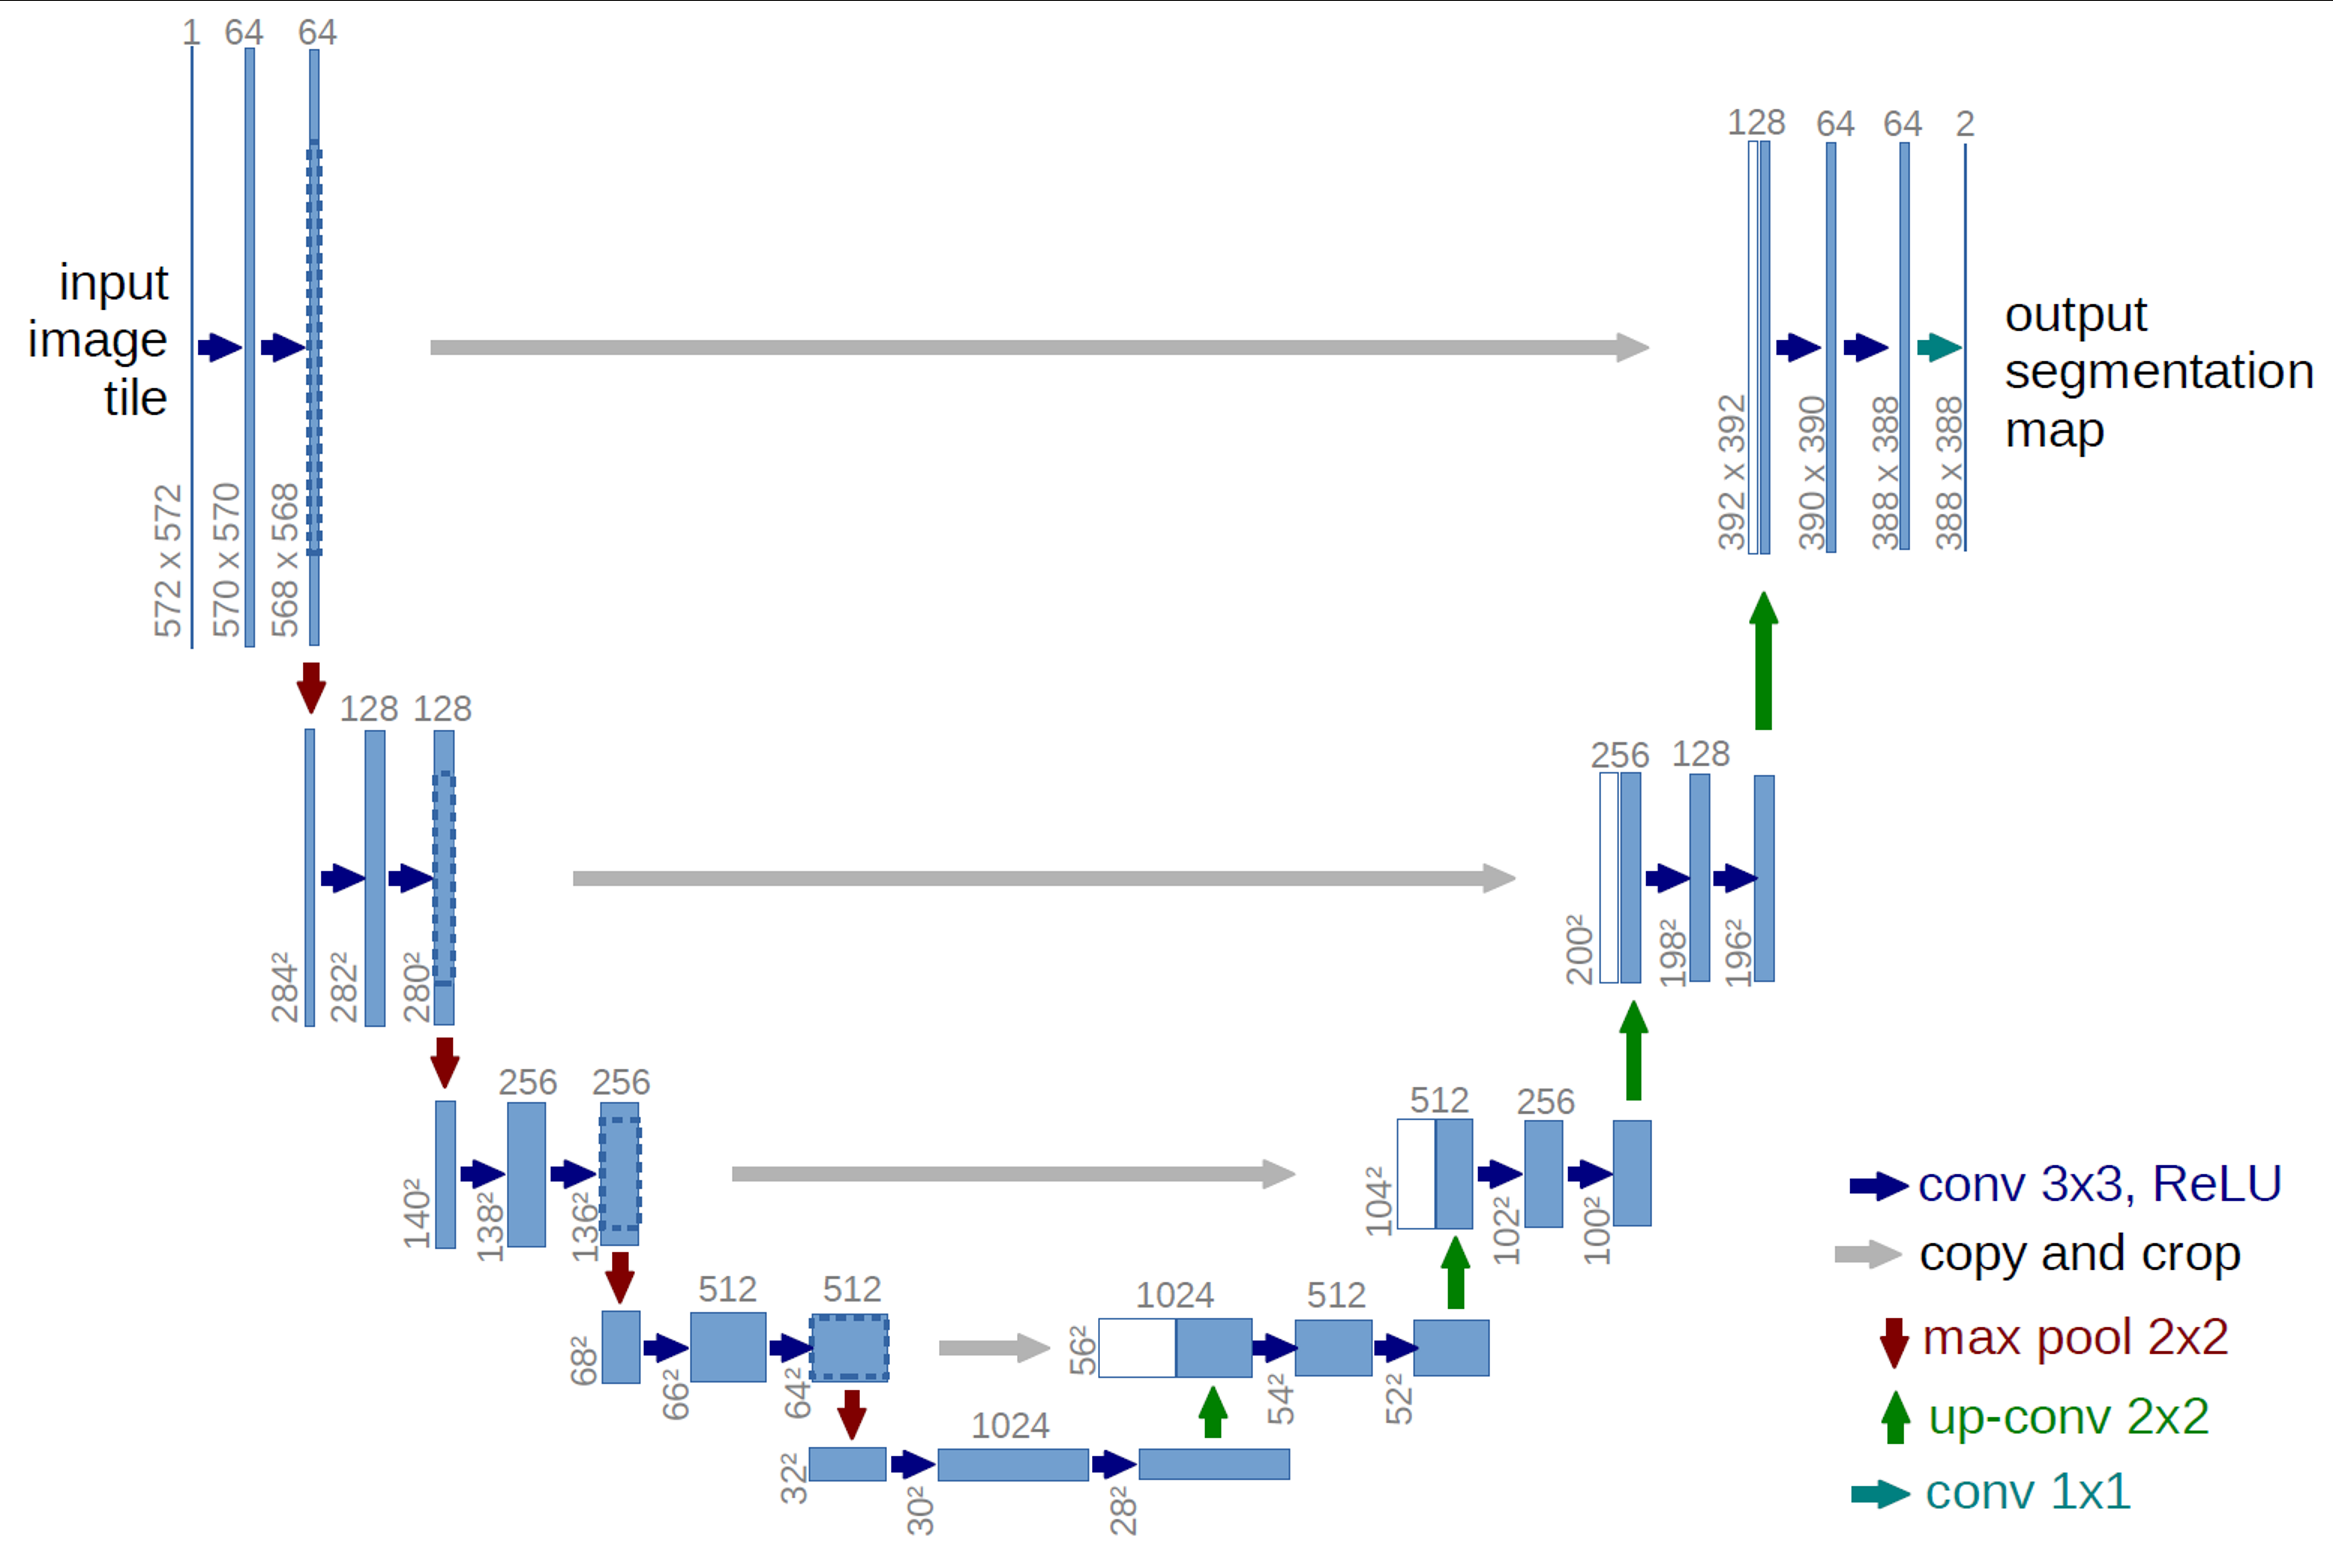

In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms.functional as f
import torch.optim as optim

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x
    
# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.enc1 = UNetBlock(3,64)
#         self.enc2 = UNetBlock(64,128)

#         self.pool = nn.MaxPool2d(2)

#         self.up1 = nn.ConvTranspose2d(128, 64, 2)
        
#         self.dec1 = UNetBlock(128, 64)

#         self.output = nn.Conv2d(64,1,1)
    
#     def forward(self, x):
#         x1 = self.enc1(x)
#         x2 = self.up1(self.enc2(self.pool(x1)))

#         x1_cropped = f.center_crop(x1, [x2.shape[2], x2.shape[3]])
        
#         x3 = self.output(self.dec1(torch.cat([x1_cropped,x2], dim=1)))

#         return torch.sigmoid(x3)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = UNetBlock(3,64)
        self.enc2 = UNetBlock(64,128)
        self.enc3 = UNetBlock(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.up1 = nn.ConvTranspose2d(128, 64, 2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2)
        
        self.dec1 = UNetBlock(128, 64)
        self.dec2 = UNetBlock(256, 128)

        self.output = nn.Conv2d(64,1,1)
    
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.up2(self.enc3(self.pool(x2)))

        x2_cropped = f.center_crop(x2, [x3.shape[2], x3.shape[3]])
        x4 = self.up1(self.dec2(torch.cat([x2_cropped, x3], dim=1)))
        
        x1_cropped = f.center_crop(x1, [x4.shape[2], x4.shape[3]])
        x5 = self.output(self.dec1(torch.cat([x1_cropped,x4], dim=1)))

        return torch.sigmoid(x5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = UNet()
unet.to(device)     # only works for NVIDIA GPUs

criterion = nn.BCELoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-4, weight_decay=1e-5)

epochs = 1

for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    for i, data in enumerate(trainLoader, 0):
        image, mask = data

        optimizer.zero_grad()
        outputs = unet(image)
        outputs = nn.functional.interpolate(outputs, size=mask.shape[2:], mode="bilinear", align_corners=False)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        with torch.no_grad():
            preds = outputs > 0.5
            correct = (preds == mask).float().sum()
            acc = correct / torch.numel(preds)
            running_acc += acc.item()


        if(i % 20 == 19):
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}, accuracy: {running_acc / 20:.3f}')
            running_loss = 0.0
            running_acc = 0.0

cpu
